In [81]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [82]:
import numpy as np
import pandas as pd

In [83]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [84]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [85]:
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [86]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [87]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [88]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [89]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [90]:
# Create the inspector and connect it to the engine
inspector = inspect(engine)

In [91]:
# Collect the names of tables within the database
inspector.get_table_names()

['measurement', 'station']

In [92]:
# Using the inspector to print the column names within the 'dow' table and its types
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [93]:
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

In [104]:
# Get the lastest dates
latest_date = (session.query(Measurement.date).order_by(Measurement.date.desc()).first())

# Convert to string 
latest_date = list(np.ravel(latest_date))[0]

# Convert to datetime Object
latest_date = dt.datetime.strptime(lastest_date, '%Y-%m-%d')

# Extract Year , month and day as integers
latest_year = int(dt.datetime.strftime(latest_date, '%Y'))
latest_month = int(dt.datetime.strftime(latest_date, '%m'))
latest_day = int(dt.datetime.strftime(latest_date, '%d'))

# One Year before the lastest day
year_before = dt.date(latest_year, latest_month, latest_day) - dt.timedelta(days=365)

# Design a query to retrieve the last 12 months of precipitation data and plot the results

prcp_data = (session.query(Measurement.date, Measurement.prcp)\
             .filter(Measurement.date > year_before)\
             .order_by(Measurement.date)\
             .all())


datetime.date(2016, 8, 23)

In [106]:
# Calculate the date 1 year ago from the last data point in the database
year_before

datetime.date(2016, 8, 23)

In [111]:
# Perform a query to retrieve the data and precipitation scores
year_before_prcp_data = (session.query(Measurement.date, Measurement.prcp)\
             .filter(Measurement.date == year_before)\
             .all())

year_before_prcp_data

[('2016-08-23', 0.0),
 ('2016-08-23', 0.15),
 ('2016-08-23', 0.05),
 ('2016-08-23', None),
 ('2016-08-23', 0.02),
 ('2016-08-23', 1.79),
 ('2016-08-23', 0.7)]

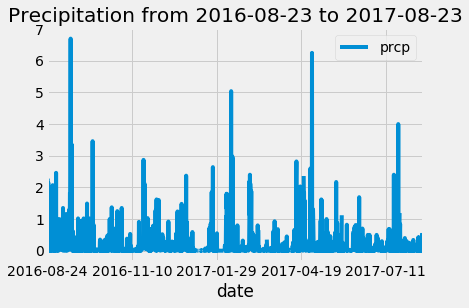

In [117]:
# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prcp_data)
prcp_df = prcp_df.set_index('date')

# Sort the dataframe by date
prcp_df = prcp_df.sort_index(ascending=True)
# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot(title="Precipitation from 2016-08-23 to 2017-08-23")
plt.show()

![precipitation](Images/precipitation.png)

In [118]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [122]:
# Design a query to show how many stations are available in this dataset?
stations_count = session.query(Station).count()
print(f"Station Count: {stations_count}")

Station Count: 9


In [129]:
# What are the most active stations? (i.e. what stations have the most rows)?
station_row_counts = (session.query(Measurement.station, func.count(Measurement.station))
                        .group_by(Measurement.station)
                        .order_by(func.count(Measurement.station).desc())
                        .all())

mostActive_station_ID = station_row_counts[0][0]

mostActive_station_name = (session.query(Station.name)
                      .filter_by(station = mostActive_station_ID))

mostActive_station_name = mostActive_station_name[0][0]

print(f"The most active station is {mostActive_station_ID}: {mostActive_station_name}.")

# List the stations and the counts in descending order.
station_row_counts



The most active station is USC00519281: WAIHEE 837.5, HI US.


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [147]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

#Highest: 
highest_temp = (session.query(Measurement.tobs)\
                .filter(Measurement.station == mostActive_station_ID)\
                .order_by(Measurement.tobs.desc())
                .first())

highest_temp = highest_temp[0]
print(f"The highest temperature recorded is {highest_temp} degrees F")

# Lowest: 
lowest_temp = (session.query(Measurement.tobs)\
                .filter(Measurement.station == mostActive_station_ID)\
                .order_by(Measurement.tobs.asc())
                .first())

lowest_temp = lowest_temp[0]
print(f"The lowest temperature recorded is {lowest_temp} degrees F")

# Average: 
avg_temp = (session.query(func.avg(Measurement.tobs))\
            .filter(Measurement.station == mostActive_station_ID))
avg_temp = avg_temp[0]
print(f"The average temperature recorded is {avg_temp} degrees F")


The highest temperature recorded is 85.0 degrees F
The lowest temperature recorded is 54.0 degrees F
The average temperature recorded is (71.66378066378067,) degrees F


In [152]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

station_by_temps = (session.query(Measurement.station, func.avg(Measurement.tobs))
                        .group_by(Measurement.station)
                        .order_by(func.avg(Measurement.tobs).desc())
                        .all())
station_by_temps 

[('USC00514830', 74.8732970027248),
 ('USC00517948', 74.68440233236151),
 ('USC00519397', 74.55323054331865),
 ('USC00519523', 74.5436493068565),
 ('USC00518838', 72.72407045009784),
 ('USC00513117', 72.68918420081211),
 ('USC00519281', 71.66378066378067),
 ('USC00511918', 71.61596766043456),
 ('USC00516128', 70.91500765696784)]

In [155]:
# Highest average temp station ID: 
highest_temp_station_ID = station_by_temps[0][0]
highest_temp_station_ID

'USC00514830'

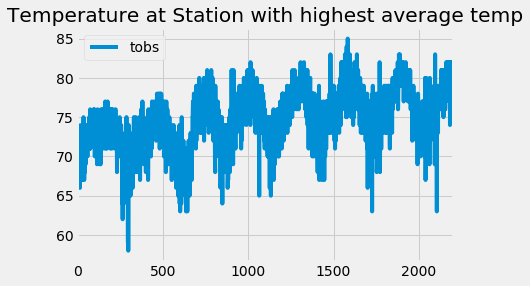

In [170]:
last_year_temp = (session.query(Measurement.station, Measurement.tobs)\
             .filter(Measurement.station == highest_temp_station_ID)\
             .all())
last_year_temp_df = pd.DataFrame(last_year_temp)
last_year_temp_df.plot(title="Temperature at Station with highest average temp")


![precipitation](Images/station-histogram.png)

In [172]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [187]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
# My travel day will be from '2017-09-01' to '2017-09-05'
trip = '2016-09-01 to 2016-09-05'
tripStart = '2016-09-01'
tripEnd = '2016-09-05'
trip_temp = calc_temps('2016-09-01', '2016-09-05')
trip_temp

[(73.0, 78.82758620689656, 84.0)]

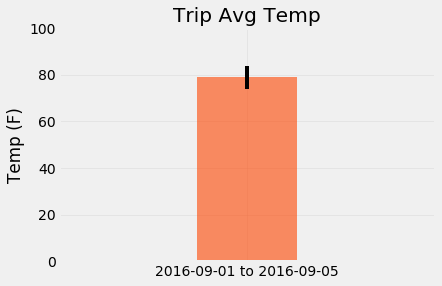

In [188]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
min_trip_temp = trip_temp[0][0]
avg_trip_temp = trip_temp[0][1]
max_trip_temp = trip_temp[0][2]

min_error = int(avg_trip_temp - min_trip_temp)
max_error = int(max_trip_temp - avg_trip_temp)

errorBars = np.array([[min_error],[max_error]])


plt.bar(trip, avg_trip_temp, yerr=errorBars, color = 'orangered', alpha = .6)
plt.ylim(0, 100)
plt.xlim(-1.5, 1.5)
plt.title('Trip Avg Temp')
plt.ylabel('Temp (F)')
plt.grid(alpha=.3)


In [193]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
sel = ([Station.station, 
        Station.name, 
        func.sum(Measurement.prcp), 
        Station.latitude, 
        Station.longitude, 
        Station.elevation
       ])

stationRain = (session.query(*sel)
                   .filter(Station.station == Measurement.station)
                   .filter(Measurement.date >= tripStart)
                   .filter(Measurement.date <= tripEnd)
                   .group_by(Station.station)
                   .order_by(func.sum(Measurement.prcp).desc())
                   .all())

stationRainDf = pd.DataFrame(np.array(stationRain))

stationRainDf = stationRainDf.rename(columns={0: "Station", 1: "Location", 
                                                    2: "Total Precipitation", 3: "Latitude", 
                                                    4: "Longitude", 5: "Elevation"})

stationRainDf


,Station,Location,Total Precipitation,Latitude,Longitude,Elevation
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",1.66,21.3331,-157.803,152.4
1,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",0.84,21.3356,-157.711,19.5
2,USC00519281,"WAIHEE 837.5, HI US",0.32,21.4517,-157.849,32.9
3,USC00513117,"KANEOHE 838.1, HI US",0.23,21.4234,-157.802,14.6
4,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",0.19,21.5213,-157.837,7
5,USC00519397,"WAIKIKI 717.2, HI US",0.03,21.2716,-157.817,3
6,USC00517948,"PEARL CITY, HI US",None,21.3934,-157.975,11.9


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


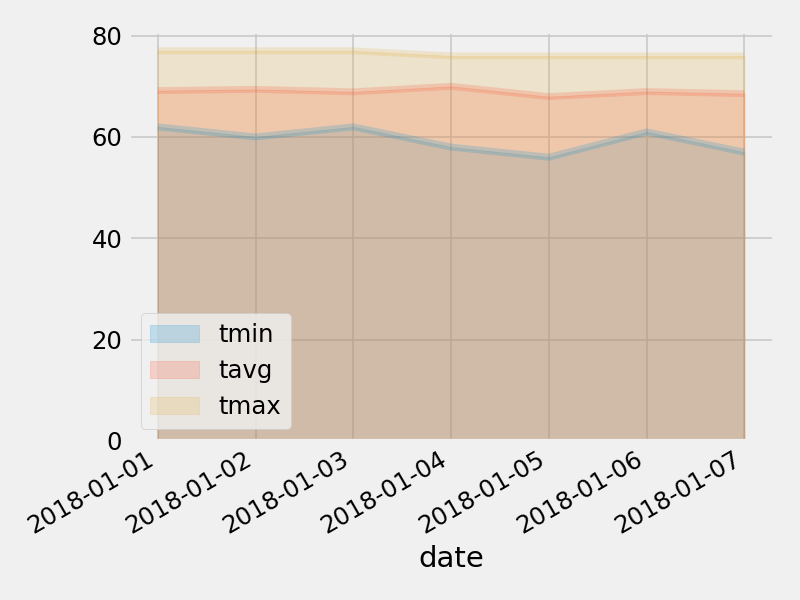

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
